Date
2018-03-26 00:00:00-04:00    2658.550049
2018-03-27 00:00:00-04:00    2612.620117
2018-03-28 00:00:00-04:00    2605.000000
2018-03-29 00:00:00-04:00    2640.870117
2018-04-02 00:00:00-04:00    2581.879883
                                ...     
2023-03-20 00:00:00-04:00    3951.570068
2023-03-21 00:00:00-04:00    4002.870117
2023-03-22 00:00:00-04:00    3936.969971
2023-03-23 00:00:00-04:00    3948.719971
2023-03-24 00:00:00-04:00    3970.989990
Name: Close, Length: 1259, dtype: float64


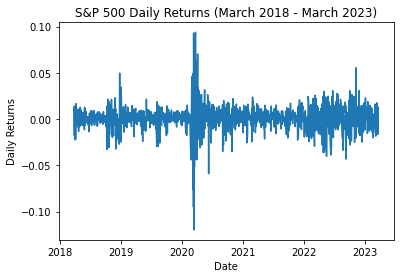

In [10]:
#import libraries
#yfinance library is used to import stock data
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Index: S&P500 - start date, and end date
symbol = "^GSPC"
start_date = "2018-03-26"
end_date = "2023-03-25"

#get historical data for the specified symbol and time frame
ticker = yf.Ticker(symbol)

data = ticker.history(start=start_date, end=end_date, interval="1d", auto_adjust=True)

# print the closing price of the stock for each day in the specified time frame
print(data["Close"])

# calculate the daily returns 
#as the percent change in daily closing prices
data["returns"] = data["Close"].pct_change()

# plot a line chart of the daily percent returns
plt.plot(data.index, data["returns"])
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.title("S&P 500 Daily Returns (March 2018 - March 2023)")
plt.show()


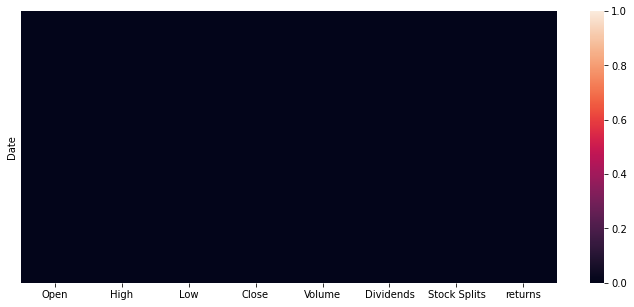

              THERE ARE NO MISSING VALUES IN THIS DATASET


The closing values of S&P500 each day: [2658.55004883 2612.62011719 2605.         ... 3936.9699707  3948.7199707
 3970.98999023]

Shape of close_values (1259,)

Length of closing values of S&P500 dataset: 1259


In [11]:
import seaborn as sns

#using a heatmap to look for any missing values within our dataset
plt.figure(figsize=(12,5))
sns.heatmap(data.isnull(),yticklabels=False)
plt.show()
print("              THERE ARE NO MISSING VALUES IN THIS DATASET\n\n")

close_values = data["Close"].values

print("The closing values of S&P500 each day:",close_values)

print("\nShape of close_values",close_values.shape)

print("\nLength of closing values of S&P500 dataset:",len(close_values))

In [12]:
#assigning values
x_minmax = close_values
x_meanstd = close_values

#assigning maximum and minimum
ymin = np.min(x_minmax)
ymax = np.max(x_minmax)

#min-max scaling to normalise the dataset
close_values_minmax = 2*((x_minmax-ymin)/(ymax-ymin)-0.5)

print("Values after Min-Max Scaling",close_values_minmax)

#compute mean and standard deviation
#and assign to variables
ymean = np.mean(x_meanstd)
ystd = np.std(x_meanstd)

#z-normalisation using mean and std of the dataset
#multiplying by 0.5 to make the values even smaller 
#inorder to achieve better model-fit
close_values_meanstd = ((x_meanstd-ymean)/ystd)*0.5

print("\n\nValues after z-normalisation",close_values_meanstd)
print("\nThe shape of close_values_meanstd:",close_values_meanstd.shape,"\n")


Values after Min-Max Scaling [-0.67086847 -0.70676301 -0.71271818 ...  0.32822486  0.33740756
  0.35481172]


Values after z-normalisation [-0.64303497 -0.67786022 -0.68363798 ...  0.32629564  0.33520479
  0.35209049]

The shape of close_values_meanstd: (1259,) 



In [19]:
#transforming the matrix to generate lags in the dataset
lagArray = close_values_meanstd.reshape(-1,1)
print("The shape of lagArray:",lagArray.shape,"\n")


#input dimension/window size for which-- 
#--one-step ahead prediction needs to be done on dataset
inputDim = 3

#output dimension
outputDim = len(lagArray) - inputDim 
#print("The value of outputDim:",outputDim,"\n")

#intitialising x1 matrix to zeros
x1 = np.zeros((outputDim,inputDim))

#intitialising y1 to zero
y1 = np.zeros(outputDim)

#for-loop to find x1 and y1 values according to input dimension
#to enable one step ahead prediction
for i in range(1, outputDim):
    
    y1[i] = lagArray[i + inputDim]
    
    for j in range(0,inputDim):
        x1[i, j] = lagArray[i-j+inputDim]
        
    #print(round(y1[i],5))

#Choosing the x1 and y1 values that fit perfectly
y1 = y1[2:(outputDim)]
x1 = x1[1:(outputDim-1)]


print("y1:\n",y1, "\n\n")
print("x1:\n",x1, "\n")

print("The shape of x1:",x1.shape,"\n")
print("The shape of y1:",y1.shape,"\n")

The shape of lagArray: (1259, 1) 

y1:
 [-0.67647279 -0.65354406 -0.63978215 ...  0.32629564  0.33520479
  0.35209049] 


x1:
 [[-0.70116825 -0.65644034 -0.68363798]
 [-0.67647279 -0.70116825 -0.65644034]
 [-0.65354406 -0.67647279 -0.70116825]
 ...
 [ 0.37626281  0.33736581  0.31088085]
 [ 0.32629564  0.37626281  0.33736581]
 [ 0.33520479  0.32629564  0.37626281]] 

The shape of x1: (1254, 3) 

The shape of y1: (1254,) 



In [20]:
#Train Set and Test-Set
x = close_values
print("Print the length of x1:",len(x1))

#setting parameters to split the data into train and test set
train_close_values = round(len(x)*0.75)
print("Train:",train_close_values)

test_close_values = round(len(x)*0.25)
print("\nTest:",test_close_values)

#training set x values
x = x1[0:(outputDim-test_close_values), 0:10]
print("\nArray x:","\n",x)
print("\nThe shape of x:",x.shape,"\n")

#training set y values
y = y1[0:(outputDim-test_close_values)]
print("\nThe shape of y:",y.shape,"\n")
print("\nArray y:","\n",y)


#test set x values
t = x1[train_close_values:(outputDim-2), 0:10]
print("\nShape of target test values matrix t:",t.shape)

#test set y values
y_test = y1[train_close_values:outputDim]
print("\nShape of target test values matrix y_test:",y_test.shape)


# transpose the array x to create the array newArray
newArray = np.transpose(x)

# print the shape of newArray and arrays x and y
print("The shape of newArray:", newArray.shape)

#assign y values to variable targets
targets = y

#print the shape of newArray
print('targets shape:', targets.shape)

#initialize variables NHID and outputVal
NHID = 7
outputVal = targets

#initialize variables NINP and NPATS
NINP, NPATS = newArray.shape

#print the values of variables NINPUTS and NPATS
print("Value of NINPUTS:", NINP, "\nValue of NPATS:", NPATS)

#initialize variables NP and NOUTPUTS
NP = targets.shape[0]
NOUTPUTS = targets.shape[0]/NP

#print the values of variables NP and NOUTPUTS
print("Value of NP:", NP, "\nValue of NOUTPUTS:", NOUTPUTS)


Print the length of x1: 1254
Train: 944

Test: 315

Array x: 
 [[-0.70116825 -0.65644034 -0.68363798]
 [-0.67647279 -0.70116825 -0.65644034]
 [-0.65354406 -0.67647279 -0.70116825]
 ...
 [ 0.80477389  0.84467181  0.88108921]
 [ 0.86634935  0.80477389  0.84467181]
 [ 0.90223623  0.86634935  0.80477389]]

The shape of x: (941, 3) 


The shape of y: (941,) 


Array y: 
 [-0.67647279 -0.65354406 -0.63978215 -0.68403986 -0.67745093 -0.64430874
 -0.65543962 -0.63891027 -0.64474098 -0.62840877 -0.60676158 -0.60505557
 -0.61681566 -0.63424725 -0.63413341 -0.66122479 -0.6575551  -0.63667354
 -0.63442163 -0.65099634 -0.64587832 -0.66038327 -0.66488708 -0.63934251
 -0.63235928 -0.63289759 -0.61328221 -0.59411424 -0.59058857 -0.58876131
 -0.60292491 -0.59457684 -0.59634357 -0.6017724  -0.58657753 -0.59307557
 -0.5863652  -0.59055821 -0.59543355 -0.61929488 -0.59340156 -0.6076107
 -0.5853567  -0.57606844 -0.57460512 -0.55674887 -0.55825014 -0.55168397
 -0.54943207 -0.5457546  -0.55426205 -0.54906054

The shape of input matrix: (4, 941)
Test Run 0: Epoch 0: Error = 6.725462507563857
Test Run 0: Epoch 1: Error = 6.482965277416085
Test Run 0: Epoch 2: Error = 6.249755217421966
Test Run 0: Epoch 3: Error = 6.0255327606480975
Test Run 0: Epoch 4: Error = 5.8100049238183
Test Run 0: Epoch 5: Error = 5.602885378476591
Test Run 0: Epoch 6: Error = 5.403894446906307
Test Run 0: Epoch 7: Error = 5.212759091297196
Test Run 0: Epoch 8: Error = 5.029212895971569
Test Run 0: Epoch 9: Error = 4.852996042584316
Test Run 0: Epoch 10: Error = 4.683855278301212
Test Run 0: Epoch 11: Error = 4.5215438770359535
Test Run 0: Epoch 12: Error = 4.365821593890853
Test Run 0: Epoch 13: Error = 4.216454612999926
Test Run 0: Epoch 14: Error = 4.073215489017585
Test Run 0: Epoch 15: Error = 3.9358830825322997
Test Run 0: Epoch 16: Error = 3.8042424897131943
Test Run 0: Epoch 17: Error = 3.6780849665198008
Test Run 0: Epoch 18: Error = 3.5572078478215405
Test Run 0: Epoch 19: Error = 3.4414144617847606
Test Run 

Test Run 0: Epoch 173: Error = 1.009487130666876
Test Run 0: Epoch 174: Error = 1.0094457828885313
Test Run 0: Epoch 175: Error = 1.009406179721235
Test Run 0: Epoch 176: Error = 1.0093682201512106
Test Run 0: Epoch 177: Error = 1.0093318088624679
Test Run 0: Epoch 178: Error = 1.009296855922472
Test Run 0: Epoch 179: Error = 1.009263276484685
Test Run 0: Epoch 180: Error = 1.0092309905071086
Test Run 0: Epoch 181: Error = 1.0091999224859869
Test Run 0: Epoch 182: Error = 1.0091700012038831
Test Run 0: Epoch 183: Error = 1.0091411594913757
Test Run 0: Epoch 184: Error = 1.009113334001662
Test Run 0: Epoch 185: Error = 1.0090864649973903
Test Run 0: Epoch 186: Error = 1.0090604961490772
Test Run 0: Epoch 187: Error = 1.009035374344499
Test Run 0: Epoch 188: Error = 1.0090110495084785
Test Run 0: Epoch 189: Error = 1.008987474432516
Test Run 0: Epoch 190: Error = 1.0089646046137424
Test Run 0: Epoch 191: Error = 1.0089423981027004
Test Run 0: Epoch 192: Error = 1.0089208153594815
Test Ru

Test Run 0: Epoch 347: Error = 1.0067978403095936
Test Run 0: Epoch 348: Error = 1.006783732789053
Test Run 0: Epoch 349: Error = 1.0067696041763459
Test Run 0: Epoch 350: Error = 1.0067554544244433
Test Run 0: Epoch 351: Error = 1.0067412834864904
Test Run 0: Epoch 352: Error = 1.0067270913157964
Test Run 0: Epoch 353: Error = 1.0067128778658199
Test Run 0: Epoch 354: Error = 1.0066986430901588
Test Run 0: Epoch 355: Error = 1.0066843869425386
Test Run 0: Epoch 356: Error = 1.0066701093768038
Test Run 0: Epoch 357: Error = 1.0066558103469054
Test Run 0: Epoch 358: Error = 1.006641489806893
Test Run 0: Epoch 359: Error = 1.0066271477109057
Test Run 0: Epoch 360: Error = 1.006612784013162
Test Run 0: Epoch 361: Error = 1.0065983986679532
Test Run 0: Epoch 362: Error = 1.0065839916296344
Test Run 0: Epoch 363: Error = 1.0065695628526166
Test Run 0: Epoch 364: Error = 1.0065551122913607
Test Run 0: Epoch 365: Error = 1.0065406399003687
Test Run 0: Epoch 366: Error = 1.0065261456341787
Tes

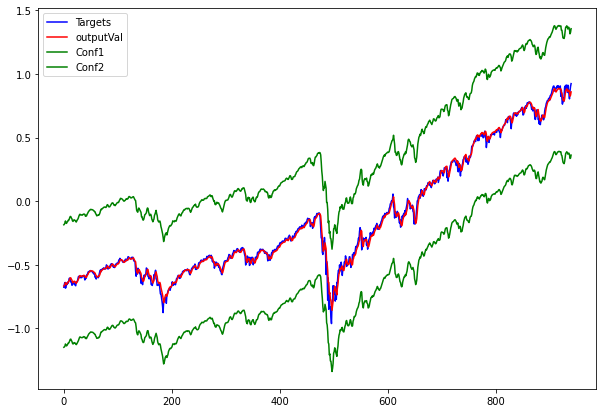

In [23]:
import scipy.io as sio

eta = 0.000025
etas = 0.0000025
#target error
L = 0.02

# initialize the best SSE
best_sse = np.inf

inputs = np.concatenate((newArray, np.ones((1, NPATS))), axis=0)
print("The shape of input matrix:", inputs.shape)


sig = np.ones((1, NP))


for i in range (1):
    np.random.seed(13)
    
    #Weights for the mean network
    w1 = 0.5 * (np.random.rand(NHID, NINP+1) - 0.5)
    w2 = 0.5 * (np.random.rand(1, NHID+1) - 0.5)
    
    #Weights for the variance network
    w1s = 0.5 * (np.random.rand(NHID, NINP+1) - 0.5)
    w2s = 0.5 * (np.random.rand(1, NHID+1) - 0.5)
    

    
    for epoch in range(0,200):
        
        #Forward propagation:
        sum1 = np.matmul(w1, inputs)
        
        #finding hidden node value by calculating tanh of the output form hidden node
        hidden = np.tanh(sum1)    
        
        #calculating dot product and output node
        #adding a bias term to the hidden node using concatenate before using dot product
        sum2 = np.dot(w2, np.concatenate((hidden, np.ones((1, NPATS))), axis=0))
        
        out = sum2 
        #outputVal = out
        
        #Backpropagation of errors of the mean network
        error = targets - out 
        
        #sum squared error
        sse = np.sum(error**2) 
        
        #error at ouput
        bout = np.divide(error,sig)
        
        #calcualting the error propogated back
        #from the output layer to the hidden layer
        bp = np.dot(w2.T, bout) 
        
        #computing the error at the hidden layer
        bh = np.multiply((1.0 - np.power(hidden, 2)), bp[:-1, :])
        
        # Computing the change in weights:
        dW2 = np.dot(bout, np.concatenate((hidden, np.ones((1, NPATS))), axis=0).T)
        dW1 = np.dot(bh, inputs.T)
            
        # Updating the weights:
        w2 = w2 + eta*dW2
        w1 = w1 + eta*dW1
        
            
    for epoch in range(0,200):
        
        #Forward propagation:
        sum1s = np.matmul(w1s, inputs) 
        
        #calculating output from hidden node by taking tanh of the output
        hiddens = np.tanh(sum1s)  
        
        #calculating dot product and output node
        #adding a bias term to the hidden node using concatenate before using dot product
        sum2s = np.dot(w2s, np.concatenate((hiddens, np.ones((1, NPATS))), axis=0))
        
        #assigning to sig the exponential of the output 
        sig = np.exp(sum2s)
              
        #Backpropagation of errors for variance network:
        error_product = np.multiply(error, error)
        error_division = np.divide(error_product, sig)
        bouts = np.divide(error_division - 1.0, 2)
        
        #calcualting the error propogated back
        #from the output layer to the hidden layer
        bps = np.dot(w2s.T, bouts) 
        
        #computing the error at the hidden layer
        bhs = np.multiply((1.0 - np.power(hiddens, 2)), bps[:-1, :])
        
        # Computing the change in weights:
        dW2s = np.dot(bouts, np.concatenate((hiddens, np.ones((1, NPATS))), axis=0).T)
        dW1s = np.dot(bhs, inputs.T)
            
        # Updating the weights:
        w2s = w2s + etas*dW2s
        w1s = w1s + etas*dW1s
        
        
        
    for epoch in range(0,500):  
        
        #Forward propagation:
        sum1 = np.matmul(w1, inputs)
        
        #finding hidden node value by calculating tanh of the output
        hidden = np.tanh(sum1)    
        
        #calculating dot product and output node
        #adding a bias term to the hidden node using concatenate before using dot product
        sum2 = np.dot(w2, np.concatenate((hidden, np.ones((1, NPATS))), axis=0))
        
        out = sum2 
        #outputVal = out
        
        
        #Backpropagation of errors:
        error = targets - out 
        sse = np.sum(error**2) 
        
        #find best sse value to get the best weights
        if sse < best_sse:
            best_sse = sse
            best_weights_mean = (w1, w2)
        
                           
        #error at ouput
        bout = np.divide(error,sig)
        
        #calcualting the error propogated back
        #from the output layer to the hidden layer
        bp = np.dot(w2.T, bout) 
        
        #computing the error at the hidden layer
        bh = np.multiply((1.0 - np.power(hidden, 2)), bp[:-1, :])
        
        # Computing the change in weights:
        dW2 = np.dot(bout, np.concatenate((hidden, np.ones((1, NPATS))), axis=0).T)
        dW1 = np.dot(bh, inputs.T)
        
        # Updating the weights:
        w2 = w2 + eta*dW2
        w1 = w1 + eta*dW1
        
        
        #variance network
        
        sum1s = np.matmul(w1s, inputs) 
        hiddens = np.tanh(sum1s)   
        
        #calculating dot product and output node
        #adding a bias term to the hidden node using concatenate before using dot product
        sum2s = np.dot(w2s, np.concatenate((hiddens, np.ones((1, NPATS))), axis=0))
        
        #assigning to sig the exponential of the output
        sig = np.exp(sum2s)
        
        #assigning value of sig to outs
        outs = sig     
        
        #Backpropagation of errors for variance network:
        error_product = np.multiply(error, error)
        error_division = np.divide(error_product, sig)
        bouts = np.divide(error_division - 1.0, 2)
        
        #calcualting the error propogated back
        #from the output layer to the hidden layer
        bps = np.dot(w2s.T, bouts) 
        
        #computing the error at the hidden layer
        bhs = np.multiply((1.0 - np.power(hiddens, 2)), bps[:-1, :])
        
        # Computing the change in weights:
        dW2s = np.dot(bouts, np.concatenate((hiddens, np.ones((1, NPATS))), axis=0).T)
        dW1s = np.dot(bhs, inputs.T)
            
        # Updating the weights:
        w2s = w2s + etas*dW2s
        w1s = w1s + etas*dW1s
        
            
          
                        
        # print the SSE for this test run
        print(f'Test Run {i}: Epoch {epoch}: Error = {sse}')
    

#Best SSE from all test runs    
print(f'Best SSE = {best_sse}')

print("Best Weights Mean Network w1:\n",w1,"\nBest Weights Mean Network w2:\n",w2)
print("Best Weights Variance Network w1s:\n",w1s,"\nBest Weights Variance Network w2s:\n",w2s)


#Flatten to 1D array to enable plotting
outputVal = out.ravel()
conf1 = outputVal + 1.645 * outs
conf1 = conf1.ravel()
conf2 = outputVal - 1.645 * outs
conf2 = conf2.ravel()

print("Targets shape:", targets.shape)
print("\noutputVal shape:", outputVal.shape)
print("\nConf1 shape:", conf1.shape)
print("\nConf2 shape:", conf2.shape)

#setting a range to plot
x_range = np.arange(0, 941)
print(targets.shape)

#plotting
plt.figure(figsize=(10, 7))
plt.plot(range(len(targets.T)), targets, 'b', label='Targets')
plt.plot(range(len(outputVal)), outputVal, 'r', label='outputVal')
plt.plot(x_range, conf1, 'g', label='Conf1')
plt.plot(x_range, conf2, 'g', label='Conf2')

plt.legend()
plt.show()


(4, 310)
(7, 310)
(1, 310)
Shape of outputVal_mean: (1, 310)
Shape of predictions mean: (310,)
w1s:
 [[-0.27149146 -0.14824651  0.08413716  0.0551956 ]
 [-0.12342592  0.08566048  0.19707201 -0.0431745 ]
 [-0.02555383 -0.12815497 -0.0650406   0.08505915]
 [ 0.14929012 -0.20279139  0.10644238 -0.06534565]
 [-0.13490394 -0.15415518 -0.08038751 -0.40502591]
 [ 0.23662324  0.11395786 -0.10697973 -0.13122335]
 [ 0.0305927  -0.21132869  0.17218294 -0.06292202]] 
w2s:
 [[-0.19960291 -0.0681462  -0.0815385   0.1256657   0.40641582  0.24800031
   0.04093676 -1.01580415]]
(7, 310)
(1, 310)
Length 1
Shape of outputVal_variance: (1, 310)
Shape of predictions variance: (310,)
length 310


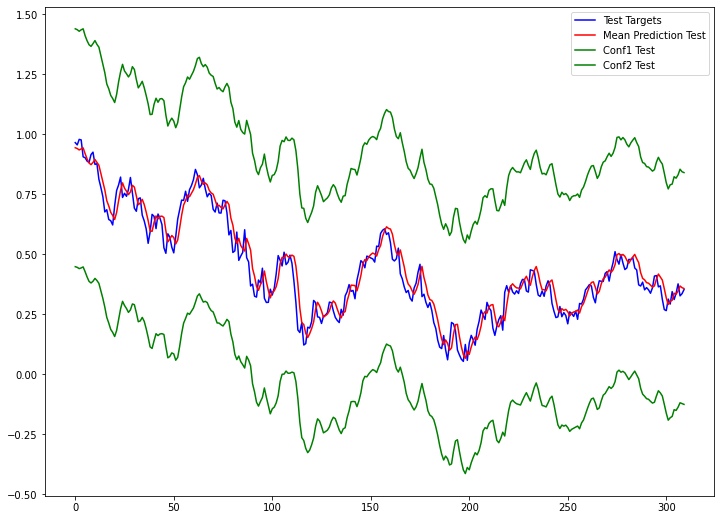

In [24]:
#Forecast the data

#mean network
#forward propogation
testinputs = np.concatenate((t.T, np.ones((1, t.shape[0]))), axis=0)
print(testinputs.shape)
sum1_m = np.matmul(w1, testinputs) 
print(sum1_m.shape)
hidden_m = np.tanh(sum1_m)
sum2_m = np.dot(w2, np.concatenate((hidden_m, np.ones((1, t.shape[0]))), axis=0))
print(sum2_m.shape)
out_m = sum2_m 
outputVal_mean = out_m 
print("Shape of outputVal_mean:",outputVal_mean.shape)

#Flatten outputVal dataset to 1DArray to visualize the data
predictions_m = outputVal_mean.ravel()
print("Shape of predictions mean:",predictions_m.shape)

print("w1s:\n",w1s,"\nw2s:\n",w2s)
#variance network
sum1_v = np.matmul(w1s, testinputs) 
print(sum1_v.shape)
hidden_v = np.tanh(sum1_v)
sum2_v = np.dot(w2s, np.concatenate((hidden_v, np.ones((1, t.shape[0]))), axis=0))
print(sum2_v.shape)
out_v = np.exp(sum2_v) 
outputVal_variance = out_v 
print("Length",len(outputVal_variance))
print("Shape of outputVal_variance:",outputVal_variance.shape)

#configuration 1
conf1_test = predictions_m + 1.645 * outputVal_variance
conf1_test = conf1_test.ravel()

#configuration 2
conf2_test = predictions_m - 1.645 * outputVal_variance
conf2_test = conf2_test.ravel()

plt.figure(figsize=(12, 9))
plt.plot(range(len(y_test)), y_test, 'b', label='Test Targets')
plt.plot(range(len(predictions_m)), predictions_m, 'r', label='Mean Prediction Test')
plt.plot(range(len(conf1_test)), conf1_test, 'g', label='Conf1 Test')
plt.plot(range(len(conf2_test)), conf2_test, 'g', label='Conf2 Test')
#Flatten outputVal dataset to 1DArray to visualize the data
predictions_v = outputVal_variance.ravel()
print("Shape of predictions variance:",predictions_v.shape)
print("length",len(predictions_v))

plt.legend()
plt.show()
